In [1]:
import pandas as pd
import spacy
import glob
import os
import re
from collections import Counter 
from collections import defaultdict
import numpy as np
from spacy.lang.en import English
from spacy.lookups import Lookups
from spacy.pipeline import EntityRuler
from spacytextblob.spacytextblob import SpacyTextBlob
import json
import sklearn
import matplotlib.pyplot as plt

In [2]:
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


all_files = glob.glob("../data/*.json")
print(all_files)

li = []
for file in all_files:
    data = pd.read_json(file)
    li.append(data)

temp = pd.concat(li, ignore_index=True)
df = temp[["tweet_id", "tweet_text"]]
print(df)

#d_types = load_data("../data/disasters/disaster_types.json")

['../data/california_wildfires_final_data.json', '../data/hurricane_harvey_final_data.json', '../data/hurricane_irma_final_data.json', '../data/hurricane_maria_final_data.json', '../data/iraq_iran_earthquake_final_data.json', '../data/mexico_earthquake_final_data.json', '../data/srilanka_floods_final_data.json']
                 tweet_id                                         tweet_text
0      917791044158185472  RT @Gizmodo: Wildfires raging through Northern...
1      917791130590183424      PHOTOS: Deadly wildfires rage in California  
2      917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...
3      917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...
4      917792092100988928  RT @TIME: California's raging wildfires as you...
...                   ...                                                ...
18077  881714673157980160                Get to mora and try the whole menu 
18078  881749861871362048  Mirka Mora (b.1928), noted French-born Aust

In [3]:
nlp = spacy.load("en_core_web_trf")

def create_training_data(file):
    data = load_data(file)
    disasters = data["disasters"]
    
    patterns = []
    for label, synonyms in disasters.items():
        for syn in synonyms:
            doc = nlp(syn)
            pattern_tokens = []
            for token in doc:
                lemma = token.lemma_.lower()
                # match the TEXT with a case-insensitive regex:
                # e.g. '^(?i)earthquakes?$' => 'earthquake' or 'earthquakes' in any case
                pattern_tokens.append({
                    "TEXT": {
                        "REGEX": fr"(?i)^{lemma}s?$"
                    }
                })
            patterns.append({
                "label": "DISASTER",
                "pattern": pattern_tokens,
                "id": label
            })
    return patterns

def generate_rules_n_lemma(patterns):
    if "entity_ruler" in nlp.pipe_names:
        nlp.remove_pipe("entity_ruler")

    ruler = nlp.add_pipe("entity_ruler", before="ner")
    ruler.add_patterns(patterns)

    try:
        nlp.add_pipe('spacytextblob')
    except Exception as e:
        print(f"Unable to add textblob: {e}")
        
    
    print(f"Total patterns added: {len(ruler.patterns)}")
    print(f"Sample patterns: {ruler.patterns[:5]}")  # Print first 5 to verify
    
    nlp.to_disk("disaster_ner")

patterns = create_training_data("../data/disasters/disaster_types.json")
generate_rules_n_lemma(patterns)

Total patterns added: 46
Sample patterns: [{'label': 'DISASTER', 'pattern': [{'TEXT': {'REGEX': '(?i)^earthquakes?$'}}], 'id': 'Earthquake'}, {'label': 'DISASTER', 'pattern': [{'TEXT': {'REGEX': '(?i)^seismics?$'}}, {'TEXT': {'REGEX': '(?i)^events?$'}}], 'id': 'Earthquake'}, {'label': 'DISASTER', 'pattern': [{'TEXT': {'REGEX': '(?i)^tremors?$'}}], 'id': 'Earthquake'}, {'label': 'DISASTER', 'pattern': [{'TEXT': {'REGEX': '(?i)^tsunamis?$'}}], 'id': 'Tsunami'}, {'label': 'DISASTER', 'pattern': [{'TEXT': {'REGEX': '(?i)^tidals?$'}}, {'TEXT': {'REGEX': '(?i)^waves?$'}}], 'id': 'Tsunami'}]


In [10]:
#load gazetteer

columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "featureClass",
    "featureCode",
    "countryCode",
    "cc2",
    "stateCode",
    "admin2Code",
    "admin3Code",
    "admin4Code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modificationDate"
]

dtypes = {
    "geonameid": "int64",
    "name": "string",
    "asciiname": "string",
    "alternatenames": "string",
    "latitude": "float64",
    "longitude": "float64",
    "featureClass": "string",
    "featureCode": "string",
    "countryCode": "string",
    "cc2": "string",
    "stateCode": "string",
    "admin2Code": "string",
    "admin3Code": "string",
    "admin4Code": "string",
    "population": "int64",
    "elevation": "float64",      # or "Int64" if you want nullable integer
    "dem": "int64",
    "timezone": "string",
    "modificationDate": "string" # Could parse as date later doesn't matter too much though
}

gazetteer_df = pd.read_csv("../data/US.txt", 
                           sep="\t",
                          names=columns,
                          dtype=dtypes,
                          header=None,
                          low_memory=False)

gazetteer_df["alternate_list"] = gazetteer_df["alternatenames"] \
    .fillna("") \
    .apply(lambda x: x.split(","))

gazetteer_df = gazetteer_df[[
    "geonameid",
    "name",
    "alternate_list",
    "countryCode",
    "stateCode",
    "latitude",
    "longitude",
    "featureCode",
    "population"
]]

print(gazetteer_df.head())

   geonameid                 name    alternate_list countryCode stateCode  \
0    2130830          Middle Reef                []          US        AK   
1    2130833        McArthur Reef                []          US        AK   
2    2130890          Buldir Reef                []          US        AK   
3    3577483          The Narrows     [The Narrows]          US        00   
4    3715657  Cape Lookout Shoals  [Lookout Shoals]          US        NC   

   latitude  longitude featureCode  population  
0  51.98414  176.01982         RFU           0  
1  52.06667  177.86667         RFU           0  
2  52.15229  176.35675         RFU           0  
3  18.37502  -64.72517         CHN           0  
4  34.51206  -76.49326        SHOL           0  


In [11]:
doc = nlp("Tsunami")
for token in doc:
    print(token.text, token.lemma_)

Tsunami Tsunami


In [7]:
#TESTING
pattern = re.compile(
    r"(?P<hashtag>\#[A-Za-z0-9_]+)"           # e.g. #RockIsland
    r"|(?P<mention>@[A-Za-z0-9_]+)"           # remove entire @-mention
    r"|(?P<url>\w+://\S+)"                    # remove entire url
    r"|(?P<remove>[^\w\s,])"                  # remove any other char that's not word char, whitespace, or comma
)

def split_camel_case(text: str) -> str:
    """
    Insert a space before an uppercase char that follows a lowercase char.
    e.g. 'RockIsland' -> 'Rock Island'
    """
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)

def replace_func(match: re.Match) -> str:
    """
    - If hashtag is matched, split its camel case part and add a comma afterward.
    - If mention or url is matched, replace with space.
    - If remove is matched (any disallowed char), replace with a space.
    """
    if match.group('hashtag'):
        # Remove the '#' and split the remainder
        hashtag_text = match.group('hashtag')[1:]  # skip '#'
        splitted = split_camel_case(hashtag_text)
        return splitted + ","  # keep a trailing comma
    
    if match.group('mention') or match.group('url') or match.group('remove'):
        return " "
    
    # fallback
    return match.group(0)

def clean_text(text: str) -> str:
    """
    Cleans the text by:
    - Removing or transforming selected tokens (@mentions, URLs, certain punctuation)
    - Normalizing extra spaces.
    - Preserving commas and splitting camel case only in hashtags.
    """
    cleaned = pattern.sub(replace_func, text)
    # Normalize spaces
    return ' '.join(cleaned.split())

nlp = spacy.load("disaster_ner")
def test_model(text):
    doc = nlp(clean_text(text))
    for ent in doc.ents:
        print(f"Entity lemma: {ent.lemma_.lower()} | Ent text: {ent.text} | Label: {ent.label_} | Canonical label: {ent.ent_id_}")
    print(f"Polarity: {doc._.blob.polarity}, Subjectivity: {doc._.blob.subjectivity}")
#print(df1.loc[0, "tweet_text"])

In [10]:
cleaned_text = clean_text("PAH extends time of Flood Warning for Caldwell, Christian, Crittenden, Hopkins, Livingston, Lyon, McLean, Muhlenberg, Trigg, Webster [KY] till Apr 10, 10:00 AM CDT Link #RockIsland #AustinTexas #SanMateo")
print(cleaned_text)
test_model(cleaned_text)

PAH extends time of Flood Warning for Caldwell, Christian, Crittenden, Hopkins, Livingston, Lyon, McLean, Muhlenberg, Trigg, Webster KY till Apr 10, 10 00 AM CDT Link Rock Island, Austin Texas, San Mateo,
Entity lemma: pah | Ent text: PAH | Label: ORG | Canonical label: 
Entity lemma: flood | Ent text: Flood | Label: DISASTER | Canonical label: Flood
Entity lemma: caldwell | Ent text: Caldwell | Label: GPE | Canonical label: 
Entity lemma: christian | Ent text: Christian | Label: PERSON | Canonical label: 
Entity lemma: crittenden | Ent text: Crittenden | Label: GPE | Canonical label: 
Entity lemma: hopkins | Ent text: Hopkins | Label: GPE | Canonical label: 
Entity lemma: livingston | Ent text: Livingston | Label: GPE | Canonical label: 
Entity lemma: lyon | Ent text: Lyon | Label: GPE | Canonical label: 
Entity lemma: mclean | Ent text: McLean | Label: GPE | Canonical label: 
Entity lemma: muhlenberg | Ent text: Muhlenberg | Label: GPE | Canonical label: 
Entity lemma: trigg | Ent te

In [13]:
#extract entities and sentiment from tweet text

headers = ["Negative", "Neutral", "Positive"]
def extract_ent_sent(text):
    #print(text)
    doc = nlp(clean_text(text))
    disasters = set()
    locations = []
    sentiment = headers[1]
    score = doc._.blob.polarity
    
    for ent in doc.ents:
        if ent.label_ == "DISASTER":
            disaster_id = ent.ent_id_ if ent.ent_id_ else ent.text
            disasters.add(disaster_id)
        elif ent.label_ in ["GPE", "LOC", "FAC"]:
            location = ent.text.strip("# ").lower()
            if location.endswith("'s"):
                location = location[:-2]
            elif location.endswith("’s"):
                location = location[:-2]
            locations.append(location)
    
    if score >= 0.1:
        sentiment = headers[2]
    elif score < 0:
        sentiment = headers[0]
    else:
        sentiment = headers[1]

    return {"disasters": disasters, "locations": locations, "sentiment": sentiment, "polarity": score}


(array(['Negative', 'Neutral', 'Positive'], dtype=object), array([365, 904, 320]))
AVG: -0.005510065220895327
STD: 0.2564690835373256


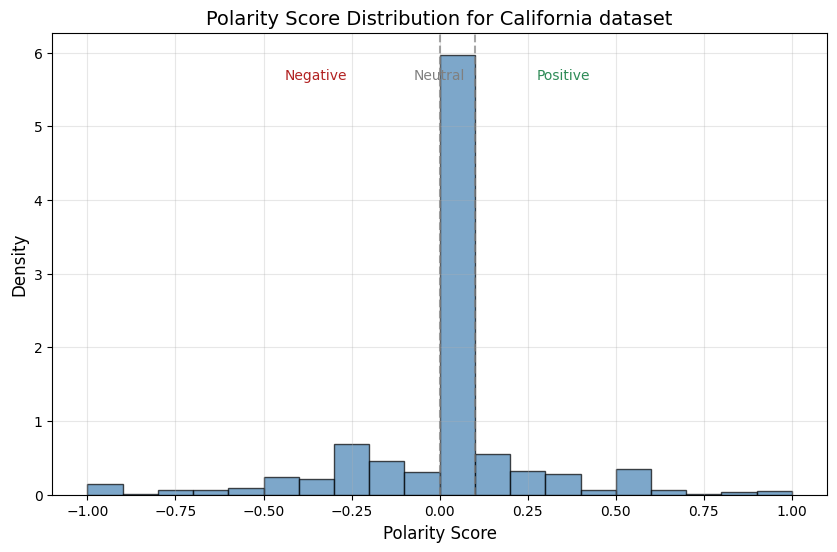

In [9]:
#Testing sentiment on california dataset, and graphing

cali_df = pd.read_json("../data/california_wildfires_final_data.json")
cali_df = cali_df[["tweet_id", "tweet_text"]]

cali_df.loc[:, ["disasters", "locations", "sentiment", "polarity"]] = cali_df["tweet_text"].apply(
    lambda x: pd.Series(extract_ent_sent(x))
)

#print(cali_df.head())

#get scores
scores = cali_df["polarity"].values
avg_scores = cali_df["polarity"].mean()
scores_std = cali_df["polarity"].std()
sentiment = cali_df["sentiment"].values
print(np.unique(sentiment, return_counts=True))
print(f"AVG: {avg_scores}\nSTD: {scores_std}")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(scores, bins=20, range=(-1, 1), 
         edgecolor='black', alpha=0.7, 
         color='steelblue', density=True)

# Add labels and style
plt.title('Polarity Score Distribution for California dataset', fontsize=14)
plt.xlabel('Polarity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, alpha=0.3)

# Add reference lines for typical sentiment thresholds
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(0.1, color='gray', linestyle='--', alpha=0.7)
plt.text(-0.35, plt.ylim()[1]*0.9, 'Negative', ha='center', color='firebrick')
plt.text(0, plt.ylim()[1]*0.9, 'Neutral', ha='center', color='gray')
plt.text(0.35, plt.ylim()[1]*0.9, 'Positive', ha='center', color='seagreen')

plt.show()

In [78]:
# process all datasets together for dash demo

# processing only cali dataset change back calidf to df when done

calidf = pd.read_json("../data/california_wildfires_final_data.json")
calidf = calidf[["tweet_id", "tweet_text"]]
try:
    print("Processing datasets...")
    calidf.loc[:, ["disasters", "locations", "sentiment", "polarity"]] = calidf["tweet_text"].apply(
        lambda x: pd.Series(extract_ent_sent(x))
    )
except Exception as e:
    print(f"Failed to process all datasets: {e}")

Processing datasets...


In [137]:
print(calidf.head())
df = calidf.copy()

             tweet_id                                         tweet_text  \
0  917791044158185472  RT @Gizmodo: Wildfires raging through Northern...   
1  917791130590183424      PHOTOS: Deadly wildfires rage in California     
2  917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...   
3  917791291823591424  RT @Cal_OES: PLS SHARE: Were capturing wildfir...   
4  917792092100988928  RT @TIME: California's raging wildfires as you...   

    disasters              locations sentiment  polarity  
0  {Wildfire}  [northern california]  Negative      -1.0  
1  {Wildfire}           [california]  Negative      -0.2  
2  {Wildfire}                     []   Neutral       0.0  
3  {Wildfire}                     []   Neutral       0.0  
4  {Wildfire}           [california]   Neutral       0.0  


In [53]:
# new stuff
#print(df.head())
#print(df[df.sentiment != 'Neutral'].head())

#filtering all neutral counts to just get average of pos - neg values
filtered = df[df.sentiment != 'Neutral'].explode("disasters").explode('locations').dropna()

crisis_counts = (
    filtered.groupby(["disasters", "locations"])
    .agg(
        count=('disasters', 'size'),
        avg_sentiment=('polarity', 'mean')
    )
    .reset_index()
    .sort_values("count", ascending=False)
    .round({'avg_sentiment': 2})
)

print(crisis_counts)


   disasters            locations  count  avg_sentiment
15  Wildfire           california    386          -0.02
54  Wildfire  northern california     27          -0.11
17  Wildfire          californias     16          -0.04
63  Wildfire           santa rosa      7           0.02
75  Wildfire         the bay area      4          -0.20
..       ...                  ...    ...            ...
76  Wildfire               topeka      1           0.70
77  Wildfire           tubbs fire      1          -0.05
80  Wildfire            wisconsin      1          -0.20
81  Wildfire             yosemite      1           0.10
82  Wildfire           zuma beach      1           0.10

[83 rows x 4 columns]


In [43]:
# calculating severity:
mean = crisis_counts["count"].mean()
std = crisis_counts["count"].std()

#z score
crisis_counts["severity"] = (crisis_counts["count"] - mean) / std

print(crisis_counts)

   disasters            locations  count  avg_sentiment  severity
15  Wildfire           california    386          -0.02  8.971937
54  Wildfire  northern california     27          -0.11  0.479393
17  Wildfire          californias     16          -0.04  0.219175
63  Wildfire           santa rosa      7           0.02  0.006270
75  Wildfire         the bay area      4          -0.20 -0.064698
..       ...                  ...    ...            ...       ...
76  Wildfire               topeka      1           0.70 -0.135666
77  Wildfire           tubbs fire      1          -0.05 -0.135666
80  Wildfire            wisconsin      1          -0.20 -0.135666
81  Wildfire             yosemite      1           0.10 -0.135666
82  Wildfire           zuma beach      1           0.10 -0.135666

[83 rows x 5 columns]


In [14]:
US_STATE_NAMES = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
    "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
    "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah",
    "VT": "Vermont", "VA": "Virginia", "WA": "Washington", "WV": "West Virginia",
    "WI": "Wisconsin", "WY": "Wyoming", "DC": "District of Columbia"
}

def lookup_city_state_country(loc_text, gaz_df, loc_dict):
    if not loc_text:
        return None

    normed = loc_text.lower().strip()
    if normed not in loc_dict:
        return None

    row_indices = loc_dict[normed]
    if not row_indices:
        return None

    matches = gaz_df.loc[row_indices]
    if matches.empty:
        return None

    best = matches.sort_values("population", ascending=False).iloc[0]
    feature_code = best["featureCode"]
    place_name   = best["name"]
    country_code = best["countryCode"]
    admin1_code  = best["stateCode"]

    city_name = None
    state_name = None
    region = None

    if pd.isna(feature_code):
        city_name = place_name
    else:
        feature_code = str(feature_code)  # Ensure it's a string
        if feature_code == "ADM1":
            # State-level record: no city, state from admin1_code.
            city_name = None
            if admin1_code in US_STATE_NAMES:
                state_name = US_STATE_NAMES[admin1_code]
            else:
                state_name = admin1_code
        elif feature_code.startswith("PPL"):
            # Populated place: assign the place name as city,
            # and try to get state from admin1_code.
            city_name = place_name
            if admin1_code in US_STATE_NAMES:
                state_name = US_STATE_NAMES[admin1_code]
            else:
                state_name = None
        elif feature_code.startswith("ADM"):
            # Other administrative levels (e.g., ADM2: county-level)
            city_name = place_name
            if admin1_code in US_STATE_NAMES:
                state_name = US_STATE_NAMES[admin1_code]
            else:
                state_name = None
        else:
            city_name = place_name

    # If no state is found, clear the city so it doesn't duplicate the region,
    # and set region to the returned place_name (unless it's US California).
    all_us_states = [s.lower() for s in US_STATE_NAMES.values()] + [code.lower() for code in US_STATE_NAMES.keys()]

    # Simple region rule: if the entire normalized text is exactly a US state name/abbreviation, don't set a region.
    if not state_name:
        city_name = None
        if normed in all_us_states:
            region = None
        else:
            region = normed.title()  # convert to title-case for display

    if region:
        for state in US_STATE_NAMES.values():
            if state.lower() in region.lower():
                state_name = state  # override or set state to the one found in region
                break
    
    return {
        "city": city_name,
        "state": state_name,
        "region": region,
        "country": country_code
    }


In [15]:
#building dictionary once

location_dict = {}
for i, row in gazetteer_df.iterrows():
    if pd.notna(row["name"]):
        main = row["name"].lower()
        location_dict.setdefault(main, []).append(i)

    alt_list = row["alternate_list"]
    if alt_list is not None and isinstance(alt_list, list):
        for alt in alt_list:
            alt_lower = alt.strip().lower()
            if alt_lower:
                location_dict.setdefault(alt_lower, []).append(i)

In [30]:
cal_rows = gazetteer_df[gazetteer_df["name"].str.lower() == "california"].sort_values("population", ascending=False).head()
print(cal_rows[["name", "countryCode", "stateCode", "featureCode", "population"]])

               name countryCode stateCode featureCode  population
1273356  California          US        CA        ADM1    39512223
303345   California          US        MD         PPL       11857
1123795  California          US        PA         PPL        6608
332716   California          US        MO       PPLA2        4396
240098   California          US        KY         PPL          86


In [17]:
def standardize_all_locations(locations_list, gaz_df, loc_dict):
    """
    For each location in the locations_list, do a lookup with
    lookup_city_state_country(...). Return a list of dicts, each containing
    {"original": <the raw location text>,
     "city": ...,
     "state": ...,
     "region": ...,
     "country": ...}
    """
    if not isinstance(locations_list, list):
        return []  # No locations or invalid format => empty

    results = []
    for loc_text in locations_list:
        match_result = lookup_city_state_country(loc_text, gaz_df, loc_dict)
        if match_result:
            results.append({
                "original": loc_text,
                "city": match_result["city"],
                "state": match_result["state"],
                "region": match_result["region"],
                "country": match_result["country"]
            })
        else:
            # If not found, still record the original location
            results.append({
                "original": loc_text,
                "city": None,
                "state": None,
                "region": None,
                "country": None
            })
    return results

def standardize_locations_column(df):
    """
    Create a new column 'all_locations' in df, which is a list of dictionaries,
    one per recognized location in 'locations'.
    """
    # We'll assume 'df' has a 'locations' column with a list of location strings.
    df = df.copy()  # To avoid modifying in place, if you prefer
    df["all_locations"] = df["locations"].apply(
        lambda loc_list: standardize_all_locations(loc_list, gazetteer_df, location_dict)
    )
    return df

# Now 'df["all_locations"]' is a list of dicts for each row. E.g.:
# [
#   {"original": "gaza",   "city": "Gaza", "state": "Iowa", "region": None, "country": "US"},
#   {"original": "china",  "city": None,   "state": None,   "region": "china", "country": "???"},
#   ...
# ]
#
# You can further process these results as you wish.


In [ ]:
def test_single_tweet(tweet_text, locations_list):
    """
    Given:
      tweet_text: The text of the tweet (for your own reference/logging).
      locations_list: The list of location strings extracted from the tweet.
    Use the already loaded gazetteer_df, location_dict, and
    standardize_all_locations(...) to see how each location is standardized.
    """
    print("Tweet text:\n", tweet_text, "\n")
    print("Raw locations list:", locations_list)

    # Standardize them all
    results = standardize_all_locations(locations_list, gazetteer_df, location_dict)

    print("\nStandardized results:")
    for loc_info in results:
        original = loc_info["original"]
        city = loc_info["city"]
        state = loc_info["state"]
        region = loc_info["region"]
        country = loc_info["country"]

        print(f"  Original = {original!r}")
        print(f"    city    = {city}")
        print(f"    state   = {state}")
        print(f"    region  = {region}")
        print(f"    country = {country}\n")

# Example usage:
tweet_text = "I just saw heavy flooding in Buffalo, also something going on in Canada."
locations_list = ["Buffalo", "Canada"]  # Suppose you extracted these from the tweet
test_single_tweet(tweet_text, locations_list)


In [7]:
def standardize_row_og(row):
    # row["locations"] is a list or possibly empty
    locs = row["locations"]
    
    # Pick the first location if available.
    if isinstance(locs, list) and len(locs) > 0:
        loc_text = locs[0]
    else:
        loc_text = None

    if not loc_text:
        return pd.Series({"city": None, "state": None, "region": None, "country": None})
    
    # Perform the lookup.
    match_result = lookup_city_state_country(loc_text, gazetteer_df, location_dict)
    if match_result:
        # If no state is found, assign the region to the original loc_text.
        region_val = loc_text if match_result["state"] is None else None
        return pd.Series({
            "city": match_result["city"],
            "state": match_result["state"],
            "region": match_result["region"],
            "country": match_result["country"]
        })
    else:
        return pd.Series({"city": None, "state": None, "region": None, "country": None})


new_cols = df.apply(standardize_row, axis=1)
df = df.copy()
df["city"] = new_cols["city"]
df["state"] = new_cols["state"]
df["region"] = new_cols["region"]
df["country"] = new_cols["country"]

print(df)
print(calidf)

NameError: name 'standardize_row' is not defined

In [134]:
df = df.dropna(subset=["state"])
exploded = df.explode("disasters")

grouped = (
    exploded.groupby(["country", "state", "disasters"])
    .agg(
        count=('tweet_id', 'size'),
        avg_sentiment=('polarity', 'mean'),
        cities=('city', lambda x: list(set(x.dropna())))
    )
    .reset_index()
    .sort_values("count", ascending=False)
    .round({'avg_sentiment': 2})
)
print(grouped)


   country          state   disasters  count  avg_sentiment  \
6       US     California    Wildfire    777          -0.01   
9       US        Florida    Wildfire      9          -0.04   
3       US     California   Hurricane      5           0.10   
21      US           Ohio    Wildfire      5           0.00   
20      US       New York    Wildfire      4           0.07   
24      US          Texas    Wildfire      3           0.00   
10      US          Idaho    Wildfire      2          -0.10   
1       US     California  Earthquake      2           0.00   
7       US       Colorado    Wildfire      2           0.17   
2       US     California    Heatwave      2          -0.20   
22      US         Oregon    Wildfire      2           0.00   
12      US         Kansas    Wildfire      2           0.10   
16      US      Minnesota    Wildfire      2          -0.08   
15      US      Minnesota   Hurricane      2          -0.08   
18      US  New Hampshire    Wildfire      2           

In [16]:
locdf = pd.read_csv("../data/disasters/geocorpora_1544784178012.tsv", sep="\t", encoding="utf-8", encoding_errors="replace")
#filtering by US only
us_locdf = locdf[locdf["country_code"] == "US"].copy()
print(len(us_locdf), "location mentions in the US")

1234 location mentions in the US


In [24]:
# 1. Build Gold DataFrame
def build_gold_locations_df(geo_df):
    """
    geo_df: DataFrame with columns:
       - tweet_id_str: unique tweet IDs
       - tweet_text: full tweet text
       - toponym: gold-labeled location text
    Returns a DataFrame with columns:
       tweet_id_str, tweet_text, locations (a list of gold location strings)
    """
    rows = []
    for tweet_id, group in geo_df.groupby("tweet_id_str"):
        tweet_text = group["tweet_text"].iloc[0]
        gold_locs = list({row["toponym"].strip() for _, row in group.iterrows() if pd.notna(row["toponym"])})
        rows.append({"tweet_id_str": tweet_id, "tweet_text": tweet_text, "locations": gold_locs})
    return pd.DataFrame(rows)

# ----------------------------
# 2. Build Predicted DataFrame by Running spaCy
def build_pred_locations_df(geo_df, nlp):
    """
    geo_df: DataFrame with columns: tweet_id_str, tweet_text
    nlp: spaCy model
    Returns a DataFrame with columns:
       tweet_id_str, tweet_text, locations (a list of predicted location strings)
    """
    rows = []
    unique_tweets = geo_df[["tweet_id_str", "tweet_text"]].drop_duplicates("tweet_id_str")
    for _, row in unique_tweets.iterrows():
        tweet_id = row["tweet_id_str"]
        text = clean_text(str(row["tweet_text"]))
        # Optionally, you can preprocess the text here (e.g., split camel case) if needed.
        doc = nlp(text)
        predicted_locs = [ent.text.strip() for ent in doc.ents if ent.label_ in ["GPE", "LOC", "FAC"]]
        rows.append({"tweet_id_str": tweet_id, "tweet_text": text, "locations": predicted_locs})
    return pd.DataFrame(rows)

# ----------------------------
# 3. Matching Helpers for String-Based Evaluation
def match_exact(gold_list, pred_list):
    gold_set = set(gold_list)
    pred_set = set(pred_list)
    tp_set = gold_set & pred_set
    fp_set = pred_set - gold_set
    fn_set = gold_set - pred_set
    return list(tp_set), list(fp_set), list(fn_set)

def match_partial(gold_list, pred_list):
    """
    For each predicted string, we say it matches a gold string if:
      p in g or g in p (case-insensitive).
    Returns:
      tp_pairs: list of (gold_string, pred_string) pairs that match,
      fp_list: predicted items with no match,
      fn_list: gold items with no match.
    """
    matched_gold_idx = set()
    matched_pred_idx = set()
    gold_list = list(gold_list)
    pred_list = list(pred_list)
    
    tp_pairs = []  # list of (gold, pred)
    for i, p in enumerate(pred_list):
        for j, g in enumerate(gold_list):
            if j not in matched_gold_idx:
                if p in g or g in p:
                    tp_pairs.append((g, p))
                    matched_pred_idx.add(i)
                    matched_gold_idx.add(j)
                    break
    fp_list = [pred_list[i] for i in range(len(pred_list)) if i not in matched_pred_idx]
    fn_list = [gold_list[j] for j in range(len(gold_list)) if j not in matched_gold_idx]
    return tp_pairs, fp_list, fn_list

# ----------------------------
# 4. Evaluation Function (Returns a DataFrame for per-tweet results)
def evaluate_location_strings_df(gold_df, pred_df, id_col="tweet_id_str", partial=True):
    """
    gold_df: DataFrame with columns [tweet_id_str, tweet_text, locations] from gold data.
    pred_df: DataFrame with columns [tweet_id_str, tweet_text, locations] from predictions.
    partial: if True, use substring matching; if False, use exact matching.
    
    Returns:
      results_df: DataFrame with per-tweet evaluation details.
      global_scores: dict with overall precision, recall, f1.
    """
    global_tp = 0
    global_fp = 0
    global_fn = 0
    results_list = []
    
    # Merge gold and predicted DataFrames on tweet_id_str (outer join)
    merged = pd.merge(gold_df, pred_df, on=id_col, how="outer", suffixes=("_gold", "_pred"))
    
    for _, row in merged.iterrows():
        # Gold list from gold_df; if missing, use empty list.
        gold_list = row["locations_gold"] if isinstance(row["locations_gold"], list) else []
        gold_list = [g.strip().lower() for g in gold_list if g]
        
        # Predicted list from pred_df; if missing, use empty list.
        pred_list = row["locations_pred"] if isinstance(row["locations_pred"], list) else []
        pred_list = [p.strip().lower() for p in pred_list if p]
        
        if partial:
            tp_items, fp_items, fn_items = match_partial(gold_list, pred_list)
            tp = len(tp_items)
        else:
            tp_items, fp_items, fn_items = match_exact(gold_list, pred_list)
            tp = len(tp_items)
        fp = len(fp_items)
        fn = len(fn_items)
        
        global_tp += tp
        global_fp += fp
        global_fn += fn
        
        results_list.append({
            id_col: row[id_col],
            "tweet_text": row["tweet_text_gold"] if pd.notna(row["tweet_text_gold"]) else row.get("tweet_text_pred", ""),
            "gold": gold_list,
            "pred": pred_list,
            "tp": tp_items,  # for partial: list of (gold, pred) pairs; for exact: list of strings
            "fp": fp_items,
            "fn": fn_items
        })
    
    precision = global_tp / (global_tp + global_fp + 1e-9)
    recall = global_tp / (global_tp + global_fn + 1e-9)
    f1 = 2.0 * precision * recall / (precision + recall + 1e-9)
    
    results_df = pd.DataFrame(results_list)
    global_scores = {"precision": precision, "recall": recall, "f1": f1}
    return results_df, global_scores

# ----------------------------
# 5. Debug Print Function for False Positives/Negatives
def print_fp_fn_samples_df(results_df, max_print=5):
    """
    Print up to max_print tweets (rows in results_df) that have false positives or false negatives.
    """
    count = 0
    for _, row in results_df.iterrows():
        fp = row["fp"]
        fn = row["fn"]
        if (fp and len(fp) > 0) or (fn and len(fn) > 0):
            print("="*60)
            print("Tweet ID:", row["tweet_id_str"])
            print("Tweet Text:", row["tweet_text"])
            print("\nGold strings:", row["gold"])
            print("Predicted strings:", row["pred"])
            if row["tp"]:
                print("\nTrue Positives:")
                if isinstance(row["tp"], list) and row["tp"]:
                    if isinstance(row["tp"][0], tuple):
                        for g, p in row["tp"]:
                            print(f"   GOLD='{g}' matched PRED='{p}'")
                    else:
                        for item in row["tp"]:
                            print("  ", item)
            if fp:
                print("\nFalse Positives:")
                for item in fp:
                    print("   ", item)
            if fn:
                print("\nFalse Negatives:")
                for item in fn:
                    print("   ", item)
            count += 1
            if count >= max_print:
                break


In [143]:
# ----------------------------
# Build gold DataFrame (gold_df) from us_locdf.
gold_df = build_gold_locations_df(us_locdf)

# Build predicted DataFrame (pred_df) by running your spaCy model on tweet texts.
pred_df = build_pred_locations_df(us_locdf, nlp)

# Evaluate using partial matching (a predicted location is considered correct if it appears in a gold string)
results_df, global_scores = evaluate_location_strings_df(gold_df, pred_df, id_col="tweet_id_str", partial=True)
print("Global Scores:", global_scores)

Global Scores: {'precision': 0.526122823097593, 'recall': 0.4965397923871137, 'f1': 0.5109034262912409}


In [144]:
print_fp_fn_samples_df(results_df, max_print=20)

Tweet ID: 485860902244454400
Tweet Text: It's happening: Border Patrol personnel infected by illegal immigrant flood - http://t.co/1kzYw6UZu2 And we are flying them all over the US

Gold strings: ['united states']
Predicted strings: ['us']

False Positives:
    us

False Negatives:
    united states
Tweet ID: 485875912941256704
Tweet Text: US scientist Professor Yoshihiro Kawaoka's mutated #H1N1 flu virus 'poses a ... - The Independent : http://t.co/wvR77oZHsG

Gold strings: ['united states']
Predicted strings: ['us']

False Positives:
    us

False Negatives:
    united states
Tweet ID: 485966456081747969
Tweet Text: Flood becomes tourism attraction -  From the locals to the... http://t.co/mhEluMJMZA
 #GlennCarey #MississippiRiver #PamArevalo #RiverDrive

Gold strings: ['mississippi river']
Predicted strings: ['the glenn carey', 'mississippi river', 'pam arevalo', 'river drive']

True Positives:
   GOLD='mississippi river' matched PRED='mississippi river'

False Positives:
    the gle

In [133]:
#testing now
test_data = [
    {
        "tweet_id": 1,
        "tweet_text": "Just felt a huge Earthquake near Los Angeles, CA. Hope everyone is okay."
    },
    {
        "tweet_id": 2,
        "tweet_text": "Breaking: Wildfire and Seismic Event shaking Northern California right now!"
    },
    {
        "tweet_id": 3,
        "tweet_text": "Massive Wildfire reported in California, strong winds are making it worse."
    },
    {
        "tweet_id": 4,
        "tweet_text": "Major Flood warnings issued for Houston, Texas due to heavy rainfall."
    },
    {
        "tweet_id": 5,
        "tweet_text": "A Cyclone is forming off the coast near Galveston, TX. Stay safe, everyone!"
    },
    {
        "tweet_id": 6,
        "tweet_text": "Hurricane Irma heading toward Miami—locals urged to evacuate promptly."
    },
    {
        "tweet_id": 7,
        "tweet_text": "Officials warn of a possible Tsunami near Sendai in Japan after the quake."
    },
    {
        "tweet_id": 8,
        "tweet_text": "Tidal Wave alerts for Mexico City as storm conditions worsen."
    },
    {
        "tweet_id": 9,
        "tweet_text": "Flash Flood in Phoenix, AZ has stranded multiple drivers on the highway."
    },
    {
        "tweet_id": 10,
        "tweet_text": "Volcanic Eruption reported in Hawaii’s Big Island region, magma flows visible."
    }
]

testdf = pd.DataFrame(test_data)
print("Initial DataFrame:\n", testdf)

try:
    print("Processing datasets...")
    testdf.loc[:, ["disasters", "locations", "sentiment", "polarity"]] = testdf["tweet_text"].apply(
        lambda x: pd.Series(extract_ent_sent(x))
    )
except Exception as e:
    print(f"Failed to process all datasets: {e}")

print("\nProcessed DataFrame:\n", testdf)

new_cols = testdf.apply(standardize_row, axis=1)
testdf = testdf.copy()
testdf["city"] = new_cols["city"]
testdf["state"] = new_cols["state"]
testdf["country"] = new_cols["country"]
testdf["region"] = new_cols["region"]

print(testdf)

Initial DataFrame:
    tweet_id                                         tweet_text
0         1  Just felt a huge Earthquake near Los Angeles, ...
1         2  Breaking: Wildfire and Seismic Event shaking N...
2         3  Massive Wildfire reported in California, stron...
3         4  Major Flood warnings issued for Houston, Texas...
4         5  A Cyclone is forming off the coast near Galves...
5         6  Hurricane Irma heading toward Miami—locals urg...
6         7  Officials warn of a possible Tsunami near Send...
7         8  Tidal Wave alerts for Mexico City as storm con...
8         9  Flash Flood in Phoenix, AZ has stranded multip...
9        10  Volcanic Eruption reported in Hawaii’s Big Isl...
Processing datasets...

Processed DataFrame:
    tweet_id                                         tweet_text  \
0         1  Just felt a huge Earthquake near Los Angeles, ...   
1         2  Breaking: Wildfire and Seismic Event shaking N...   
2         3  Massive Wildfire reported in C

In [ ]:
# convert to json and store in a file

print(crisis_counts)
csv = crisis_counts.to_csv('./demo/crisis_counts.csv', index=False)
print(csv)